## import

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from hsic import *

from sklearn.cluster import KMeans


## Deep network

In [2]:
class deepNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(deepNetwork, self).__init__()
        # 3 layer network
        self.fc = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.Sigmoid(),
            nn.Linear(64,64),
            nn.Sigmoid(),
            nn.Linear(64,output_dim),
        )
    def forward(self, x):
        return self.fc(x)

class kernelEncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelEncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

class kernelDncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelDncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

## Data

In [3]:
# number of sample
N = 1000
x_dim = 2 # X
y_dim = 2 # U
embedding_dim = x_dim

### dataset

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
def plot2D(points,color = 'c',title='title', axes = None):
    if points.shape[1] != 2:
        print('need 2 dimension')
        return
    if axes is not None:
        plt.subplot(axes)
    plt.title(title)
    plt.scatter(points[:,0],points[:,1],c=color)
    
    
class myDataSet(Dataset):
    def __init__(self,N):
        self.points, self.true_labels = make_moons(
            n_samples=N,
            noise=0.05,
            random_state=42
        )
        self.points = torch.DoubleTensor(self.points, device=device)
        self.labelColor = ['r' if l == 1 else 'b' for l in self.true_labels]
    
    def groupIndex(self,label):
        return self.true_labels == label

    def group(self, label):
        return self.points[self.groupIndex(label)]

    def sample(self, N):
        index = np.random.choice(self.__len__(), N, replace=False)
        return self.points[index]

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx]
    

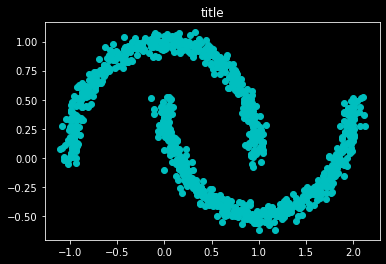

In [5]:
train_data = myDataSet(N)
plot2D(train_data.points)

# HSIC

In [6]:
hsic = HSIC(N)
hsic.selfTest()

dependent(high):  0.02400062938538282
independent(low):  7.178524782325046e-05


## Train

### hyperparameter

- Modify `initLR`, `encoderLR`, `decoderLR`, `LAMBDA`

In [18]:

encoder = kernelEncoder(N, x_dim, embedding_dim).double().to(device)
decoder = kernelDncoder(N, embedding_dim, x_dim).double().to(device)

initLR = 0.005
encoderInitOptimizer = torch.optim.Adam(encoder.parameters(),lr=initLR)
decoderInitOptimizer = torch.optim.Adam(decoder.parameters(),lr=initLR)

encoderLR = 0.004
decoderLR = 0.01
encoderOptimizer = torch.optim.Adam(encoder.parameters(),lr=encoderLR)
decoderOptimizer = torch.optim.Adam(decoder.parameters(),lr=decoderLR)

LAMBDA = 5e-2

#lr_scheduler = torch.optim.lr_scheduler.StepLR(encoder.parameters(),10,0.99,)

def f_function(x):
    return decoder(encoder(x).clone().detach())

def norm(x):
    return (x**2).sum()

### init theta

100%|██████████| 10/10 [00:00<00:00, 29.58it/s, loss=0.807]


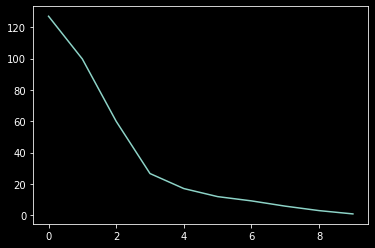

In [19]:
epoch = 10
record_loss = []
# train mode
encoder.train()
decoder.train()
tqdm_ = tqdm(range(epoch))
dataSet = DataLoader(train_data, batch_size=64, drop_last=True)
for i in tqdm_:
    for points in dataSet:
        encoderInitOptimizer.zero_grad()
        decoderInitOptimizer.zero_grad()
        
        loss = norm(points - encoder(points)) + \
            norm(points - f_function(points))
        loss.backward()
        
        encoderInitOptimizer.step()
        decoderInitOptimizer.step()
    tqdm_.set_postfix({'loss':loss.item()})

    record_loss.append(loss.item())

plt.plot(record_loss)

In [20]:
x = train_data.sample(3)
with torch.no_grad():
    print(x)
    print(encoder(x))
    print(f_function(x))

tensor([[-0.5542,  0.8496],
        [ 0.7462, -0.4332],
        [-0.6116,  0.8564]], dtype=torch.float64)
tensor([[-0.5647,  0.8212],
        [ 0.7650, -0.4633],
        [-0.6145,  0.8207]], dtype=torch.float64)
tensor([[-0.5735,  0.7805],
        [ 0.7726, -0.4478],
        [-0.6143,  0.7741]], dtype=torch.float64)


### Update U

In [21]:
def update_U(debug = False):
    embedding_k = GaussianKernelMatrix(encoder(train_data.points))
    H = hsic.H
    D = np.diag(to_cpu(embedding_k).mean(1))
    D = torch.tensor(fractional_matrix_power(np.linalg.inv(D), 0.5).real,device=device)
    L =  H @ D @ embedding_k @ D @ H
    # eigenvalue
    _, eigenvectors = np.linalg.eig(to_cpu(L))
    # top C
    U = eigenvectors[:,:y_dim].real

    if debug: # check (U^T) * U = I
        print(U.transpose() @ U)

    return torch.DoubleTensor(U).to(device)

# test I
_ = update_U(debug=True)

[[ 1.00000000e+00 -8.00954355e-17]
 [-8.00954355e-17  1.00000000e+00]]


### update loop

100%|██████████| 50/50 [00:47<00:00,  1.04it/s, loss=-13.6]


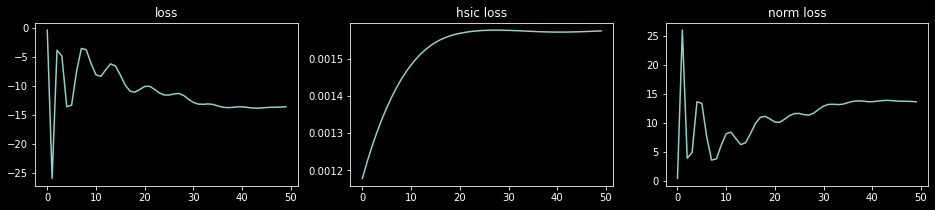

In [22]:
epoch = 50
hsic_loss = []
norm_loss = []
record_loss = []
# train mode
encoder.train()
decoder.train()

U = update_U()

tqdm_ = tqdm(range(epoch))
for i in tqdm_:
    # update theta
    points = train_data.points
    encoderOptimizer.zero_grad()
    decoderOptimizer.zero_grad()
    _hsic = hsic(encoder(points), U)
    _norm = LAMBDA * norm(points - f_function(points))
    loss = _hsic - _norm
    # SGA
    loss = -loss
    loss.backward()
    
    encoderOptimizer.step()
    decoderOptimizer.step()
    hsic_loss.append(_hsic.item())
    norm_loss.append(_norm.item())
    record_loss.append(-(loss.item()))
    
    hsic.update_D(hsic._kernel_x(points))
    U = update_U()
    tqdm_.set_postfix({'loss': -(loss.item())})
    
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(3)
fig.tight_layout()
plt.subplot(131)
plt.title("loss")
plt.plot(record_loss)
plt.ticklabel_format(useOffset=False)
plt.subplot(132)
plt.title("hsic loss")
plt.plot(hsic_loss)
plt.subplot(133)
plt.title("norm loss")
plt.plot(norm_loss)
plt.show()

## plot result

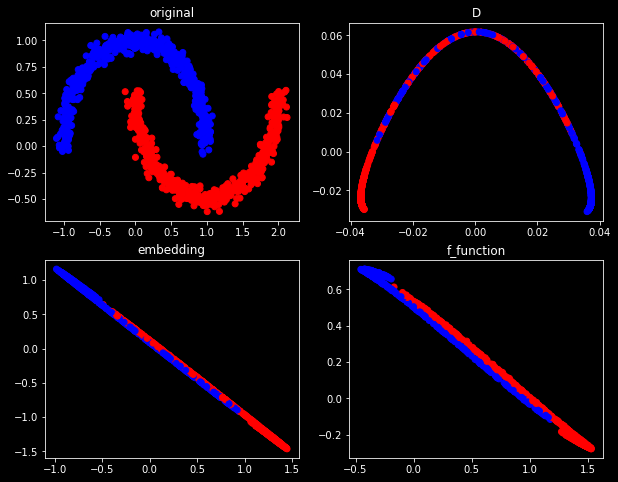

In [23]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)
fig.tight_layout()
plot2D(to_numpy(train_data.points), train_data.labelColor, title='original', axes=221)
plot2D(U,train_data.labelColor, title='D', axes=222)
plot2D(to_numpy(encoder(train_data.points)), train_data.labelColor, title='embedding', axes=223)
plot2D(to_numpy(f_function(train_data.points)), train_data.labelColor, title='f_function', axes=224)
plt.show()

<AxesSubplot:title={'center':'embedding label 1 axis-X'}, ylabel='Count'>

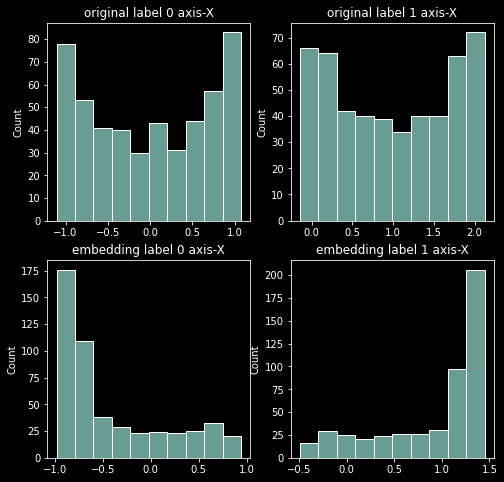

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].set_title('original label 0 axis-X')
axes[0,1].set_title('original label 1 axis-X')
axes[1,0].set_title('embedding label 0 axis-X')
axes[1,1].set_title('embedding label 1 axis-X')
sns.histplot(train_data.points[train_data.groupIndex(0),0],ax=axes[0,0])
sns.histplot(train_data.points[train_data.groupIndex(1),0],ax=axes[0,1])
sns.histplot(to_numpy(encoder(train_data.points))[train_data.groupIndex(0),0],ax=axes[1,0])
sns.histplot(to_numpy(encoder(train_data.points))[train_data.groupIndex(1),0],ax=axes[1,1])

## Accuracy

In [25]:
def toColor(label):
    return ['r' if l == 1 else 'g' for l in label]

### without embedding

acc: 0.746


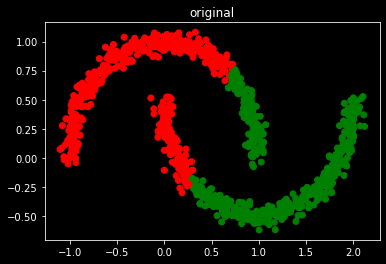

In [26]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(to_numpy(train_data.points))
correct = 0
for k,l in zip(kmeans.labels_, train_data.true_labels):
    if k == l:
        correct += 1
acc = round(correct / N,3)
print('acc:', max(acc,1-acc))
plot2D(to_numpy(train_data.points),color=toColor(kmeans.labels_) , title='original')


### apply embedding

acc: 0.823


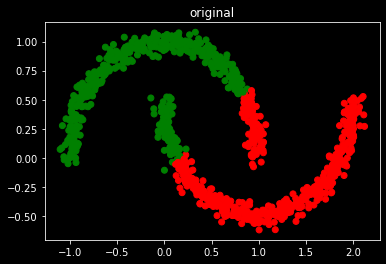

In [27]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(to_numpy(encoder(train_data.points)))
correct = 0
for k,l in zip(kmeans.labels_, train_data.true_labels):
    if k == l:
        correct += 1
acc = round(correct / N,3)
print('acc:', max(acc,1-acc))
plot2D(to_numpy(train_data.points),color=toColor(kmeans.labels_) , title='original')